<a href="https://colab.research.google.com/github/bryanMontoya/mlTalleres/blob/main/CKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Parcial**.

Jojhan Stiven Puerta Castaño.

Brayan Montoya Osorio.

In [94]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import xgboost as xgb
import shap
from shap import explainers
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Clinically Applicable Machine Learning Approaches to Identify Attributes of Chronic Kidney Disease (CKD) for Use in Low-Cost Diagnostic Screening**
MD. RASHED-AL-MAHFUZ, ABEDUL HAQUE, AKM AZAD, SALEM A. ALYAMI,
JULIAN M. W. QUINN, AND MOHAMMAD ALI MONI.

La enfermedad renal crónica es una enfermedad que causa miles de muertes alrededor del mundo. Uno de los inconvenientes mas grandes es que su detección y diagnóstico es caro y complejo.

El objetivo del artículo es crear un sistema de machine learning que realice un diagnóstico temprano de la enfermedad renal crónica (CKD). Se usan varios modelos de clasificación y una técnica de interpretación para la selección de características llamada "Shap", donde se obtienen las características que más aportan en las predicciones de los modelos. 

Por otra parte, se pretende reducir el conjunto de características del dataset que puedan describir correctamente la detección de la enfermedad. 


En primer lugar se debe realizar un pre-procesamiento de los datos, ya que algunas características contienen datos no numéricos.

In [96]:
path = 'drive/MyDrive/data/'
data = pd.read_csv(path + 'ckd.csv', sep = ';')
X = data.values
data.head(10)

,age,bp,sg,al_pre,al,su_pre,su,rbc_pre,rbc,pc_pre,pc,pcc_pre,pcc,ba_pre,ba,bgr_pre,bgr,bu_pre,bu,sc-pre,sc,sod_pre,sod,pot_pre,pot,hemo_pre,hemo,pcv_pre,pcv,wbcc_pre,wbcc,rbcc_pre,rbcc,htn_pre,htn,dm_pre,dm,cad_pre,cad,appet_pre,appet,pe_pre,pe,ane_pre,ane,label_pre,label,Unnamed: 47
0,48.0,80.0,1.020,1.0,1,0.0,0,1.0,?,1.0,normal,0.0,notpresent,0.0,notpresent,121.0,121,36.0,36,1.2,1.2,138.0,?,4.6,?,15.4,15.4,44,44,7800.0,7800,5.2,5.2,1.0,yes,1.0,yes,0.0,no,1.0,good,0.0,no,0.0,no,1.0,ckd,NaN
1,7.0,50.0,1.020,4.0,4,0.0,0,1.0,?,1.0,normal,0.0,notpresent,0.0,notpresent,148.0,?,18.0,18,0.8,0.8,138.0,?,4.6,?,11.3,11.3,38,38,6000.0,6000,4.7,?,0.0,no,0.0,no,0.0,no,1.0,good,0.0,no,0.0,no,1.0,ckd,NaN
2,62.0,80.0,1.017,2.0,2,3.0,3,1.0,normal,1.0,normal,0.0,notpresent,0.0,notpresent,423.0,423,53.0,53,1.8,1.8,138.0,?,4.6,?,9.6,9.6,31,31,7500.0,7500,4.7,?,0.0,no,1.0,yes,0.0,no,0.0,poor,0.0,no,1.0,yes,1.0,ckd,NaN
3,48.0,70.0,1.005,4.0,4,0.0,0,1.0,normal,0.0,abnormal,1.0,present,0.0,notpresent,117.0,117,56.0,56,3.8,3.8,111.0,111,2.5,2.5,11.2,11.2,32,32,6700.0,6700,3.9,3.9,1.0,yes,0.0,no,0.0,no,0.0,poor,1.0,yes,1.0,yes,1.0,ckd,NaN
4,51.0,80.0,1.010,2.0,2,0.0,0,1.0,normal,1.0,normal,0.0,notpresent,0.0,notpresent,106.0,106,26.0,26,1.4,1.4,138.0,?,4.6,?,11.6,11.6,35,35,7300.0,7300,4.6,4.6,0.0,no,0.0,no,0.0,no,1.0,good,0.0,no,0.0,no,1.0,ckd,NaN
5,60.0,90.0,1.015,3.0,3,0.0,0,1.0,?,1.0,?,0.0,notpresent,0.0,notpresent,74.0,74,25.0,25,1.1,1.1,142.0,142,3.2,3.2,12.2,12.2,39,39,7800.0,7800,4.4,4.4,1.0,yes,1.0,yes,0.0,no,1.0,good,1.0,yes,0.0,no,1.0,ckd,NaN
6,68.0,70.0,1.010,0.0,0,0.0,0,1.0,?,1.0,normal,0.0,notpresent,0.0,notpresent,100.0,100,54.0,54,24.0,24,104.0,104,4.0,4,12.4,12.4,36,36,8406.0,?,4.7,?,0.0,no,0.0,no,0.0,no,1.0,good,0.0,no,0.0,no,1.0,ckd,NaN
7,24.0,76.0,1.015,2.0,2,4.0,4,1.0,normal,0.0,abnormal,0.0,notpresent,0.0,notpresent,410.0,410,31.0,31,1.1,1.1,138.0,?,4.6,?,12.4,12.4,44,44,6900.0,6900,5.0,5,0.0,no,1.0,yes,0.0,no,1.0,good,1.0,yes,0.0,no,1.0,ckd,NaN
8,52.0,100.0,1.015,3.0,3,0.0,0,1.0,normal,0.0,abnormal,1.0,present,0.0,notpresent,138.0,138,60.0,60,1.9,1.9,138.0,?,4.6,?,10.8,10.8,33,33,9600.0,9600,4.0,4,1.0,yes,1.0,yes,0.0,no,1.0,good,0.0,no,1.0,yes,1.0,ckd,NaN
9,53.0,90.0,1.020,2.0,2,0.0,0,0.0,abnormal,0.0,abnormal,1.0,present,0.0,notpresent,70.0,70,107.0,107,7.2,7.2,114.0,114,3.7,3.7,9.5,9.5,29,29,12100.0,12100,3.7,3.7,1.0,yes,1.0,yes,0.0,no,0.0,poor,0.0,no,1.0,yes,1.0,ckd,NaN


En el pre-procesamiento de los datos se deben cambiar aquellos campos que contengan los valores 'normal', 'present', 'yes', y 'good' por un valor de 1. Los campos con los valores 'abnormal', 'notpresent', 'no', y 'poor' se reemplazan por el valor 0. 

Para llenar los campos vacíos, las características numéricas se reemplazan por la media de los valores existentes en cada una de ellas y, para las características no numéricas, se reemplazan con su respectivas modas. Este preprocesamiento se realiza a través de la herramienta Excel y el resultado se muestra a continuación:

In [97]:
nameFeatures = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'pedal_edema',
              'anemia']
path = 'drive/MyDrive/data/'
data = pd.read_csv(path + 'values.csv', sep = ';')
y = data.label
data = data.drop('label', axis = 1)
X = data.values
data.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48,80,1.020,1,0,1,1,0,0,121,36.0,1.2,138,4.6,15.4,44,7800,5.2,1,1,0,1,0,0
1,7,50,1.020,4,0,1,1,0,0,148,18.0,0.8,138,4.6,11.3,38,6000,4.7,0,0,0,1,0,0
2,62,80,1.017,2,3,1,1,0,0,423,53.0,1.8,138,4.6,9.6,31,7500,4.7,0,1,0,0,0,1
3,48,70,1.005,4,0,1,0,1,0,117,56.0,3.8,111,2.5,11.2,32,6700,3.9,1,0,0,0,1,1
4,51,80,1.010,2,0,1,1,0,0,106,26.0,1.4,138,4.6,11.6,35,7300,4.6,0,0,0,1,0,0
5,60,90,1.015,3,0,1,1,0,0,74,25.0,1.1,142,3.2,12.2,39,7800,4.4,1,1,0,1,1,0
6,68,70,1.010,0,0,1,1,0,0,100,54.0,24.0,104,4.0,12.4,36,8406,4.7,0,0,0,1,0,0
7,24,76,1.015,2,4,1,0,0,0,410,31.0,1.1,138,4.6,12.4,44,6900,5.0,0,1,0,1,1,0
8,52,100,1.015,3,0,1,0,1,0,138,60.0,1.9,138,4.6,10.8,33,9600,4.0,1,1,0,1,0,1
9,53,90,1.020,2,0,0,0,1,0,70,107.0,7.2,114,3.7,9.5,29,12100,3.7,1,1,0,0,0,1


**División de los datos**

Ahora se realiza la división de los datos entre entrenamiento y test. También se hace un escalamiento de los datos, ya que, estos deben estar en una misma escala y así evitar que algunas características con valores bajos no presenten importancia en el aprendizaje de los modelos. El método escogido para hacer el escalamiento es 'Z-score'.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 20)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Entrenamiento de los modelos.**

Se escogieron cinco modelos de clasificación para realizar las predicciones y comparar cual de todos los modelos presenta mayor desempeño. Los modelos escogidos son "Random Forest (RF)", "XGBoost (XGB)", "Gradient Boosting (GB)", "Regresión Logística (RL)" y "Máquinas de Soporte Vectorial (SVM)". A continuación se realiza el entrenamiento de cada modelo con la base de datos con todas sus características y se obtienen también las métricas de desempeño de cada uno.

**Modelo de RF**

In [99]:
RF_model = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt' , random_state = 1) 
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
y_pred_proba=RF_model.predict_proba(X_test)[:,1]
print('Accuracy en entrenamiento: {:.2f}'.format(RF_model.score(X_train, y_train)))
print('Accuracy en test: {:.2f}'.format(RF_model.score(X_test, y_test)))
metr_RF=[]
report=classification_report(y_test, y_pred, output_dict=True)
metr_RF.append(report['accuracy'])
metr_RF.append(report['1']['recall'])
metr_RF.append(report['0']['recall'])
metr_RF.append(report['1']['precision'])
metr_RF.append(report['1']['f1-score'])
metr_RF.append(roc_auc_score(y_test, y_pred_proba))

Accuracy en entrenamiento: 1.00
Accuracy en test: 1.00


Text(0.5, 1.0, 'Características más relevantes según el modelo de Random Forest')

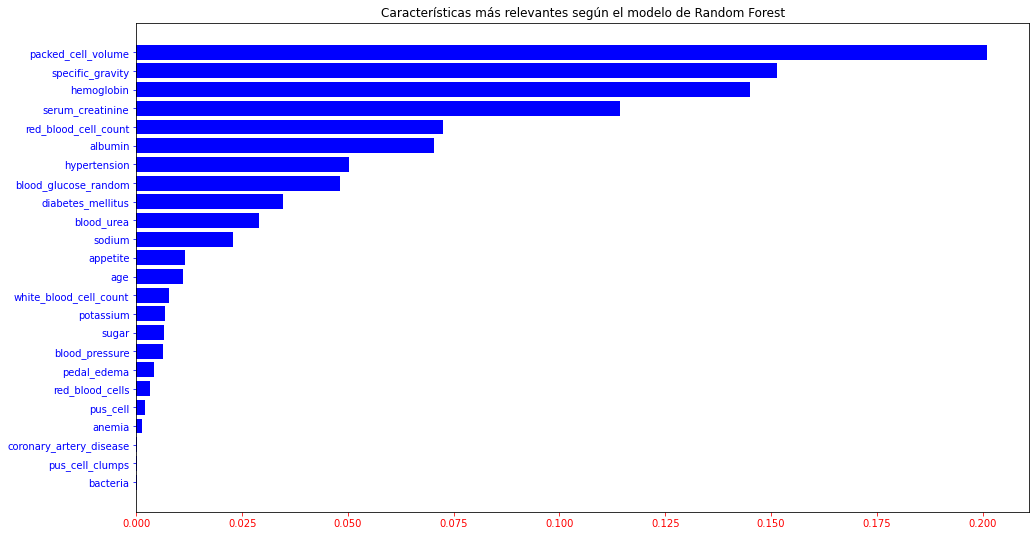

In [100]:
importances = RF_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize = (16,9))
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)),[nameFeatures[i] for i in indices]);
plt.title("Características más relevantes según el modelo de Random Forest")

**Modelo de XGB**

In [101]:
xgb_model = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba=xgb_model.predict_proba(X_test)[:,1]
print('Accuracy en entrenamiento: {:.2f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy en test: {:.2f}'.format(xgb_model.score(X_test, y_test)))
metr_XGB=[]
report=classification_report(y_test, y_pred, output_dict=True)
metr_XGB.append(report['accuracy'])
metr_XGB.append(report['1']['recall'])
metr_XGB.append(report['0']['recall'])
metr_XGB.append(report['1']['precision'])
metr_XGB.append(report['1']['f1-score'])
metr_XGB.append(roc_auc_score(y_test, y_pred_proba))

Accuracy en entrenamiento: 1.00
Accuracy en test: 0.97


**Modelo de GB**

In [102]:
gb_model = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 123)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X = X_test)
y_pred_proba=gb_model.predict_proba(X_test)[:,1]
print('Accuracy en entrenamiento: {:.2f}'.format(gb_model.score(X_train, y_train)))
print('Accuracy en test: {:.2f}'.format(gb_model.score(X_test, y_test)))
metr_GB=[]
report=classification_report(y_test, y_pred, output_dict=True)
metr_GB.append(report['accuracy'])
metr_GB.append(report['1']['recall'])
metr_GB.append(report['0']['recall'])
metr_GB.append(report['1']['precision'])
metr_GB.append(report['1']['f1-score'])
metr_GB.append(roc_auc_score(y_test, y_pred_proba))

Accuracy en entrenamiento: 1.00
Accuracy en test: 1.00


**Modelo de Regresión Logística**

In [103]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print("Accuray en entrenamiento: {:.2f}".format(logreg.score(X_train, y_train)))
print("Accuray en test: {:.2f}".format(logreg.score(X_test, y_test)))
metr_RL=[]
report=classification_report(y_test, y_pred, output_dict=True)
metr_RL.append(report['accuracy'])
metr_RL.append(report['1']['recall'])
metr_RL.append(report['0']['recall'])
metr_RL.append(report['1']['precision'])
metr_RL.append(report['1']['f1-score'])
metr_RL.append(roc_auc_score(y_test, y_pred_proba))

Accuray en entrenamiento: 1.00
Accuray en test: 0.97


**Modelo de SVM**

In [104]:
clf = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 10, probability = True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba=clf.predict_proba(X_test)[:,1]
print("Accuray en entrenamiento: {:.2f}".format(clf.score(X_train, y_train)))
print("Accuray en test: {:.2f}".format(clf.score(X_test, y_test)))
metr_SVM=[]
report=classification_report(y_test, y_pred, output_dict=True)
metr_SVM.append(report['accuracy'])
metr_SVM.append(report['1']['recall'])
metr_SVM.append(report['0']['recall'])
metr_SVM.append(report['1']['precision'])
metr_SVM.append(report['1']['f1-score'])
metr_SVM.append(roc_auc_score(y_test, y_pred_proba))

Accuray en entrenamiento: 1.00
Accuray en test: 0.97


# **Métricas**

Las métricas que se presentan muestran un buen desempeño de todos los modelos usando las 24 características del dataset, sin embargo, los modelos de Random Forest y Gradient Boosting sobresalen entre los demás modelos tal como sucede en la evaluación de los modelos según los autores del artículo.

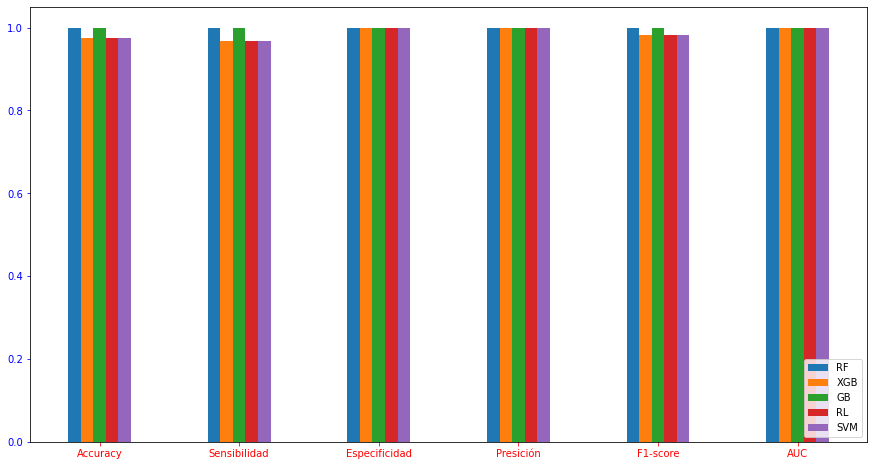

In [105]:
nameMetrics = ['Accuracy', 'Sensibilidad', 'Especificidad', 'Presición', 'F1-score', 'AUC']
i = np.arange(6)
anc = 0.09

plt.figure(figsize = (15,8), )
plt.bar(i, metr_RF, width = anc, label = 'RF')
plt.bar(i + anc,metr_XGB, width = anc, label = 'XGB')
plt.bar(i + 2*anc,metr_GB, width = anc, label = 'GB')
plt.bar(i + 3*anc,metr_RL, width = anc, label = 'RL')
plt.bar(i + 4*anc,metr_SVM, width = anc, label = 'SVM')

plt.legend(loc = 'lower right')
plt.xticks(i + 2*anc, nameMetrics);

# **Shap**

Esta técnica muestra cuales fueron las características que más aportaron al aprendizaje de cada modelo, además de eso también puede dar interpretabilidad de esas características más relevantes.

A partir de esta información se crean nuevas bases de datos, seis conjuntos de características que aportan a uno de los objetivos del artículo de encontrar un dataset óptimo que permita la detección de la enfermedad.

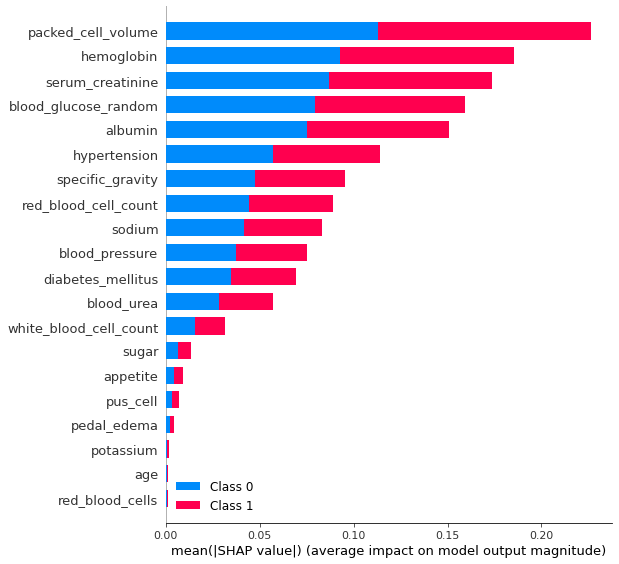

In [106]:
ex = shap.TreeExplainer(RF_model)
shap_values = ex.shap_values(X)
shap.summary_plot(shap_values, X, nameFeatures)

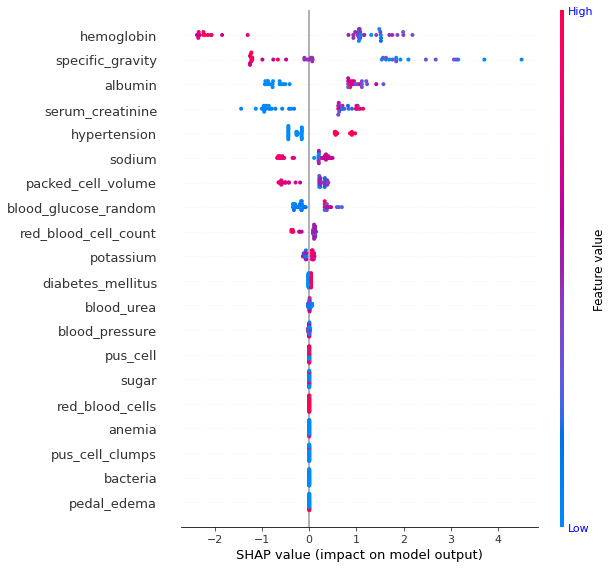

In [107]:
ex = shap.TreeExplainer(xgb_model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, nameFeatures)

Los valores Shap más altos en la gráfica anterior son los de Hemoglobina, gravedad específica, albuminuria, creatinina sérica, hipertensión, entre otros, por lo tanto estas son las características que más aportan en la evaluación del modelo de XGBoost.

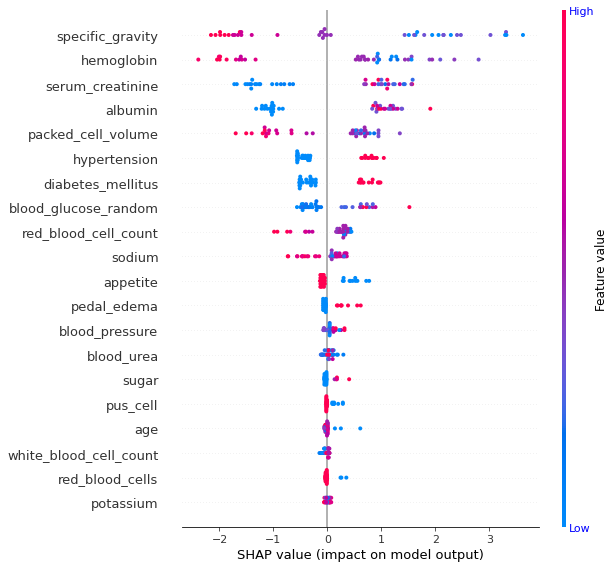

In [108]:
ex = shap.TreeExplainer(gb_model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, nameFeatures)

Los valores Shap más altos en la gráfica anterior son los de Hemoglobina, gravedad específica, albuminuria, creatinina sérica, volúmen celular, hipertensión, diabetes mellitus entre otros, por lo tanto estas son las características que más aportan en la evaluación del modelo de gradiente boosting.

In [109]:
y_predproba_train = xgb_model.predict_proba(X_train)[:,1]
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

# **Entrenamiento con nuevos conjuntos de características.**

In [110]:
models = [gb_model, logreg, RF_model, clf, xgb_model]
colnames = ['GB','LR','RF','SVM','XGB']

# **DB1**

Se genera un dataset DBI con las 13 características más relevantes según el modelo de RF, estas características son :


* Hemoglobina.
* Gravedad especifica.
* Creatinina sérica.
* Albuminuria.
* Paquete de volúmen celular.
* Conteo de glóbulos rojos.
* Hipertensión.
* Glucosa aleatoria en sangre.
* Diabetes mellitus.
* Edad.
* Sodio.
* Urea en sangre.
* Presión sanguínea.

A continuación se entrenan los 5 modelos seleccionados con este conjunto de características y se miden las métricas para ellos.



In [111]:
data.columns = nameFeatures
db1 = data
db1 = db1.drop('sugar', axis = 1)
db1 = db1.drop('coronary_artery_disease', axis = 1)
db1 = db1.drop('red_blood_cells', axis = 1)
db1 = db1.drop('pus_cell', axis = 1)
db1 = db1.drop('pus_cell_clumps', axis = 1)
db1 = db1.drop('bacteria', axis = 1)
db1 = db1.drop('potassium', axis = 1)
db1 = db1.drop('white_blood_cell_count', axis = 1)
db1 = db1.drop('appetite', axis = 1)
db1 = db1.drop('pedal_edema', axis = 1)
db1 = db1.drop('anemia', axis = 1)
X_db1 = db1.values
db1.head(10)

,age,blood_pressure,specific_gravity,albumin,blood_glucose_random,blood_urea,serum_creatinine,sodium,hemoglobin,packed_cell_volume,red_blood_cell_count,hypertension,diabetes_mellitus
0,48,80,1.020,1,121,36.0,1.2,138,15.4,44,5.2,1,1
1,7,50,1.020,4,148,18.0,0.8,138,11.3,38,4.7,0,0
2,62,80,1.017,2,423,53.0,1.8,138,9.6,31,4.7,0,1
3,48,70,1.005,4,117,56.0,3.8,111,11.2,32,3.9,1,0
4,51,80,1.010,2,106,26.0,1.4,138,11.6,35,4.6,0,0
5,60,90,1.015,3,74,25.0,1.1,142,12.2,39,4.4,1,1
6,68,70,1.010,0,100,54.0,24.0,104,12.4,36,4.7,0,0
7,24,76,1.015,2,410,31.0,1.1,138,12.4,44,5.0,0,1
8,52,100,1.015,3,138,60.0,1.9,138,10.8,33,4.0,1,1
9,53,90,1.020,2,70,107.0,7.2,114,9.5,29,3.7,1,1


In [112]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_db1, y, test_size = 0.1, random_state = 20)

In [113]:
RF_model1 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model1 = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model1 = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg1 = LogisticRegression(max_iter = 1000)
clf1 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 10, probability = True, max_iter = 1000)

RF_model1.fit(X_train,y_train)
clf1.fit(X_train,y_train)
xgb_model1.fit(X_train,y_train)
gb_model1.fit(X_train,y_train)
logreg1.fit(X_train,y_train);

In [114]:
k = 0
val_metrics = []
for model in models:    
  report = classification_report(y_test, model.predict(X_test), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

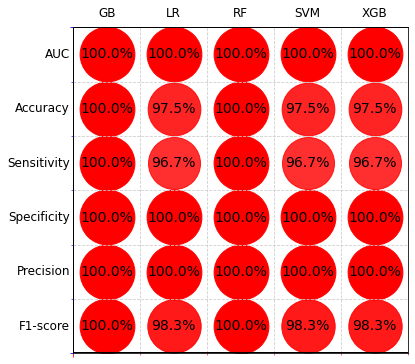

In [115]:
rownames = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'r');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **DB2**
Se genera una segunda base de datos DB2, en la cual se utilizan las características tomadas de exámenes de sangre mas otro conjunto de características generales, estas son:


* Hemoglobina.
* Creatinina sérica.
* Paquete de volúmen celular.
* Conteo de glóbulos rojos.
* Glucosa aleatoria en sangre.
* Sodio.
* Urea en sangre.
* Hipertensión.
* Diabetes mellitus.
* Edad.
* Presión sanguínea.

In [116]:
db2 = data
db2 = db2.drop('sugar', axis = 1)
db2 = db2.drop('coronary_artery_disease', axis = 1)
db2 = db2.drop('red_blood_cells', axis = 1)
db2 = db2.drop('pus_cell', axis = 1)
db2 = db2.drop('pus_cell_clumps', axis = 1)
db2 = db2.drop('bacteria', axis = 1)
db2 = db2.drop('potassium', axis = 1)
db2 = db2.drop('white_blood_cell_count', axis = 1)
db2 = db2.drop('appetite', axis = 1)
db2 = db2.drop('pedal_edema', axis = 1)
db2 = db2.drop('anemia', axis = 1)
db2 = db2.drop('specific_gravity', axis = 1)
db2 = db2.drop('albumin', axis = 1)
X_db2 = db2.values
db2.head(10)

,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,hemoglobin,packed_cell_volume,red_blood_cell_count,hypertension,diabetes_mellitus
0,48,80,121,36.0,1.2,138,15.4,44,5.2,1,1
1,7,50,148,18.0,0.8,138,11.3,38,4.7,0,0
2,62,80,423,53.0,1.8,138,9.6,31,4.7,0,1
3,48,70,117,56.0,3.8,111,11.2,32,3.9,1,0
4,51,80,106,26.0,1.4,138,11.6,35,4.6,0,0
5,60,90,74,25.0,1.1,142,12.2,39,4.4,1,1
6,68,70,100,54.0,24.0,104,12.4,36,4.7,0,0
7,24,76,410,31.0,1.1,138,12.4,44,5.0,0,1
8,52,100,138,60.0,1.9,138,10.8,33,4.0,1,1
9,53,90,70,107.0,7.2,114,9.5,29,3.7,1,1


In [117]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_db2, y, test_size = 0.1, random_state = 20)

In [118]:
RF_model2 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model2 = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model2 = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg2 = LogisticRegression(max_iter = 1000)
clf2 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 10, probability = True, max_iter = 1000)

In [142]:
k = 0
val_metrics = []
for model in models:      
  model.fit(X_train2, y_train2)
  report = classification_report(y_test2, model.predict(X_test2), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test2)[:,1]
  fpr, tpr, _ = roc_curve(y_test2,  y_pred_proba)
  auc = roc_auc_score(y_test2, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


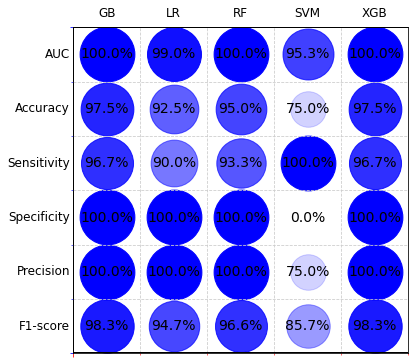

In [143]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'b');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **DB3**
Se genera una tercera base de datos DB3, en la cual se utilizan las características tomadas de exámenes de orina mas otro conjunto de características generales, estas son:


* Gravedad especifica.
* Albuminuria.
* Hipertensión.
* Diabetes mellitus.
* Edad.
* Presión sanguínea.

In [121]:
db3 = data
db3 = db3.drop('sugar', axis = 1)
db3 = db3.drop('coronary_artery_disease', axis = 1)
db3 = db3.drop('red_blood_cells', axis = 1)
db3 = db3.drop('pus_cell', axis = 1)
db3 = db3.drop('pus_cell_clumps', axis = 1)
db3 = db3.drop('bacteria', axis = 1)
db3 = db3.drop('potassium', axis = 1)
db3 = db3.drop('white_blood_cell_count', axis = 1)
db3 = db3.drop('appetite', axis = 1)
db3 = db3.drop('pedal_edema', axis = 1)
db3 = db3.drop('anemia', axis = 1)
db3 = db3.drop('blood_glucose_random', axis = 1)
db3 = db3.drop('blood_urea', axis = 1)
db3 = db3.drop('serum_creatinine', axis = 1)
db3 = db3.drop('sodium', axis = 1)
db3 = db3.drop('hemoglobin', axis = 1)
db3 = db3.drop('packed_cell_volume', axis = 1)
db3 = db3.drop('red_blood_cell_count', axis = 1)
X_db3 = db3.values
db3.head(10)

,age,blood_pressure,specific_gravity,albumin,hypertension,diabetes_mellitus
0,48,80,1.020,1,1,1
1,7,50,1.020,4,0,0
2,62,80,1.017,2,0,1
3,48,70,1.005,4,1,0
4,51,80,1.010,2,0,0
5,60,90,1.015,3,1,1
6,68,70,1.010,0,0,0
7,24,76,1.015,2,0,1
8,52,100,1.015,3,1,1
9,53,90,1.020,2,1,1


In [122]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_db3, y, test_size = 0.1, random_state = 20)

In [123]:
RF_model3 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model3 = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model3 = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg3 = LogisticRegression(max_iter = 1000)
clf3 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.1, C = 10, probability = True, max_iter = 1000)

In [144]:
k = 0
val_metrics = []
for model in models:      
  model.fit(X_train3, y_train3)
  report = classification_report(y_test3, model.predict(X_test3), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test3)[:,1]
  fpr, tpr, _ = roc_curve(y_test3,  y_pred_proba)
  auc = roc_auc_score(y_test3, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


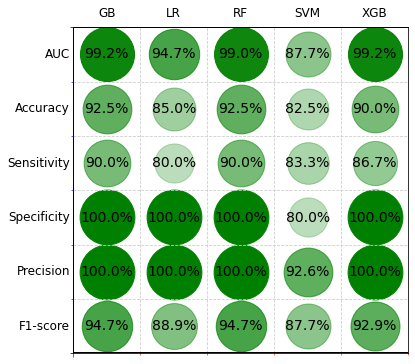

In [145]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'g');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **DB4**
La cuarta base de datos que se genera DB4, utiliza exclusivamente exámenes de sangre, los cuales arrojan el siguiente conjunto de características:

* Hemoglobina.
* Creatinina sérica.
* Paquete de volúmen celular.
* Conteo de glóbulos rojos.
* Glucosa aleatoria en sangre.
* Sodio.
* Urea en sangre.

In [126]:
db4 = data
db4 = db4.drop('sugar', axis = 1)
db4 = db4.drop('coronary_artery_disease', axis = 1)
db4 = db4.drop('red_blood_cells', axis = 1)
db4 = db4.drop('pus_cell', axis = 1)
db4 = db4.drop('pus_cell_clumps', axis = 1)
db4 = db4.drop('bacteria', axis = 1)
db4 = db4.drop('potassium', axis = 1)
db4 = db4.drop('white_blood_cell_count', axis = 1)
db4 = db4.drop('appetite', axis = 1)
db4 = db4.drop('pedal_edema', axis = 1)
db4 = db4.drop('anemia', axis = 1)
db4 = db4.drop('specific_gravity', axis = 1)
db4 = db4.drop('age', axis = 1)
db4 = db4.drop('hypertension', axis = 1)
db4 = db4.drop('diabetes_mellitus', axis = 1)
db4 = db4.drop('blood_pressure', axis = 1)
db4 = db4.drop('albumin', axis = 1)
X_db4 = db4.values
db4.head(10)

,blood_glucose_random,blood_urea,serum_creatinine,sodium,hemoglobin,packed_cell_volume,red_blood_cell_count
0,121,36.0,1.2,138,15.4,44,5.2
1,148,18.0,0.8,138,11.3,38,4.7
2,423,53.0,1.8,138,9.6,31,4.7
3,117,56.0,3.8,111,11.2,32,3.9
4,106,26.0,1.4,138,11.6,35,4.6
5,74,25.0,1.1,142,12.2,39,4.4
6,100,54.0,24.0,104,12.4,36,4.7
7,410,31.0,1.1,138,12.4,44,5.0
8,138,60.0,1.9,138,10.8,33,4.0
9,70,107.0,7.2,114,9.5,29,3.7


In [127]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_db4, y, test_size = 0.1, random_state = 20)

In [128]:
RF_model4 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model4 = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model4 = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg4 = LogisticRegression(max_iter = 1000)
clf4 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.001, C = 10, probability = True)

In [146]:
k = 0
val_metrics = []
for model in models:      
  model.fit(X_train4, y_train4)
  report = classification_report(y_test4, model.predict(X_test4), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test4)[:,1]
  fpr, tpr, _ = roc_curve(y_test4,  y_pred_proba)
  auc = roc_auc_score(y_test4, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


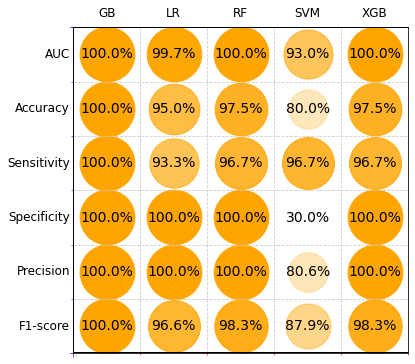

In [148]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'orange');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **DB5**
Una quinta base de datos se genera, la cual solo usa características tomadas de exámenes de orina, las características son:

* Gravedad específica.
* Albuminuria.

In [131]:
db5 = data
db5 = db5.drop('sugar', axis = 1)
db5 = db5.drop('coronary_artery_disease', axis = 1)
db5 = db5.drop('red_blood_cells', axis = 1)
db5 = db5.drop('pus_cell', axis = 1)
db5 = db5.drop('pus_cell_clumps', axis = 1)
db5 = db5.drop('bacteria', axis = 1)
db5 = db5.drop('potassium', axis = 1)
db5 = db5.drop('white_blood_cell_count', axis = 1)
db5 = db5.drop('appetite', axis = 1)
db5 = db5.drop('pedal_edema', axis = 1)
db5 = db5.drop('anemia', axis = 1)
db5 = db5.drop('age', axis = 1)
db5 = db5.drop('hypertension', axis = 1)
db5 = db5.drop('diabetes_mellitus', axis = 1)
db5 = db5.drop('blood_pressure', axis = 1)
db5 = db5.drop('blood_glucose_random', axis = 1)
db5 = db5.drop('blood_urea', axis = 1)
db5 = db5.drop('serum_creatinine', axis = 1)
db5 = db5.drop('sodium', axis = 1)
db5 = db5.drop('hemoglobin', axis = 1)
db5 = db5.drop('packed_cell_volume', axis = 1)
db5 = db5.drop('red_blood_cell_count', axis = 1)
X_db5 = db5.values
db5.head(10)

,specific_gravity,albumin
0,1.020,1
1,1.020,4
2,1.017,2
3,1.005,4
4,1.010,2
5,1.015,3
6,1.010,0
7,1.015,2
8,1.015,3
9,1.020,2


In [132]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_db5, y, test_size = 0.1, random_state = 20)

In [133]:
RF_model5 = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model5 = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model5 = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg5 = LogisticRegression(max_iter = 1000)
clf5 = SVC(kernel = 'rbf', random_state = 1, gamma = 0.001, C = 10, probability = True)

In [149]:
k = 0
val_metrics = []
for model in models:      
  model.fit(X_train5, y_train5)
  report = classification_report(y_test5, model.predict(X_test5), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test5)[:,1]
  fpr, tpr, _ = roc_curve(y_test5,  y_pred_proba)
  auc = roc_auc_score(y_test5, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

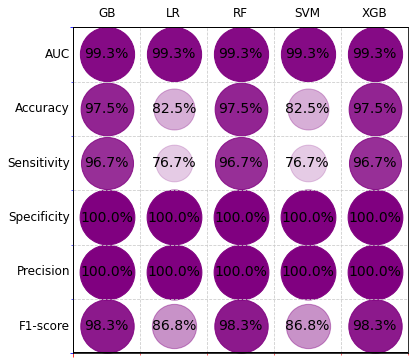

In [150]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'purple');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **DB6**
Una sexta base de datos se genera, la cual no usa características tomadas de exámenes de sangre ni de orina, las características son:

* Hipertensión.
* Diabetes mellitus.
* Edad.
* Presión sanguinea.

In [136]:
db6 = data
db6 = db6.drop('sugar', axis = 1)
db6 = db6.drop('coronary_artery_disease', axis = 1)
db6 = db6.drop('red_blood_cells', axis = 1)
db6 = db6.drop('pus_cell', axis = 1)
db6 = db6.drop('pus_cell_clumps', axis = 1)
db6 = db6.drop('bacteria', axis = 1)
db6 = db6.drop('potassium', axis = 1)
db6 = db6.drop('white_blood_cell_count', axis = 1)
db6 = db6.drop('appetite', axis = 1)
db6 = db6.drop('pedal_edema', axis = 1)
db6 = db6.drop('anemia', axis = 1)
db6 = db6.drop('specific_gravity', axis = 1)
db6 = db6.drop('albumin', axis = 1)
db6 = db6.drop('blood_glucose_random', axis = 1)
db6 = db6.drop('blood_urea', axis = 1)
db6 = db6.drop('serum_creatinine', axis = 1)
db6 = db6.drop('sodium', axis = 1)
db6 = db6.drop('hemoglobin', axis = 1)
db6 = db6.drop('packed_cell_volume', axis = 1)
db6 = db6.drop('red_blood_cell_count', axis = 1)
X_db6 = db6.values
db6.head(10)

,age,blood_pressure,hypertension,diabetes_mellitus
0,48,80,1,1
1,7,50,0,0
2,62,80,0,1
3,48,70,1,0
4,51,80,0,0
5,60,90,1,1
6,68,70,0,0
7,24,76,0,1
8,52,100,1,1
9,53,90,1,1


In [137]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_db6, y, test_size = 0.1, random_state = 20)

In [138]:
RF_model = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt', random_state = 0) 
xgb_model = XGBClassifier(n_estimators = 88, max_depth = 3, objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27)
gb_model = GradientBoostingClassifier( n_estimators = 100, max_features = 'sqrt', random_state = 4)
logreg = LogisticRegression(max_iter = 1000)
clf = SVC(kernel = 'rbf', random_state = 1, gamma = 0.05, C = 10, probability = True)

In [151]:
k = 0
val_metrics = []
for model in models:      
  model.fit(X_train6, y_train6)
  report = classification_report(y_test6, model.predict(X_test6), output_dict = True)    
  y_pred_proba = model.predict_proba(X_test6)[:,1]
  fpr, tpr, _ = roc_curve(y_test6,  y_pred_proba)
  auc = roc_auc_score(y_test6, y_pred_proba)
  val_metrics.append(auc)
  val_metrics.append(report['accuracy'])
  val_metrics.append(report['1']['recall'])
  val_metrics.append(report['0']['recall'])
  val_metrics.append(report['1']['precision'])
  val_metrics.append(report['1']['f1-score'])  
  k+=1
val_metrics = np.array(val_metrics)
val_metrics = val_metrics.reshape(len(models), 6)

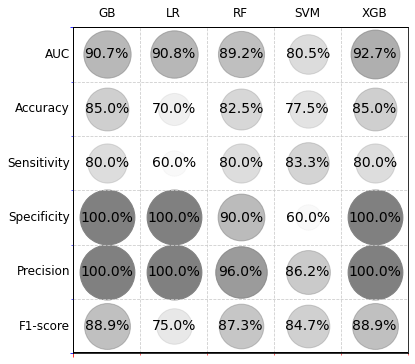

In [140]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim((0,100))
plt.ylim((0,120))
plt.grid(True)
metricas = val_metrics
# Poner nombre filas 
for i in range(5):
    plt.text(20*i+10,125, colnames[i], fontsize = 12, ha='center', va='center')
for i in range(6):
    plt.text(-1,110-20*i, rownames[i], fontsize = 12, ha='right', va='center')

for i in range(5):
    for j in range(6):
        plt.text(20*i+10,110-20*j, '{:.1f}%'.format(100*metricas[i][j]), 
                 fontsize = 14, ha = 'center', va = 'center')
        plt.scatter(20*i+10,110-20*j, s = 3000*(metricas[i][j])**3, alpha = metricas[i][j]**6, c = 'gray');

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(120))
ax.yaxis.set_major_locator(MultipleLocator(120))
# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(6))
ax.yaxis.set_minor_locator(AutoMinorLocator(6))
# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which = 'major', color = 'k', linestyle = '-', linewidth = 2)
ax.grid(which = 'minor', color = '#CCCCCC', linestyle = '--')
ax.set_xticklabels([])
ax.set_yticklabels([]);

# **Conclusiones**

*   Se demuestra que a través de los métodos de selección características, se puede reducir la dimensionalidad de un dataset, al reducir el número de estas características, se pueden simplificar los modelos de machine learning y los tiempos de ejecución tambien se ven beneficiados. 
*   Algunos métodos de selección de características como Shap no solo ayudan a reducir la dimensionalidad de un dataset, sino que tambien aportan a la interpretabilidad de las características seleccionadas, lo cual es especialmente importante en el ámbito médico.
*   El modelo de random forest (RF), presentó buenas métricas de desempeño en todos los conjuntos de características evaluados, de igual manera como le sucede a los autores en el desarrollo del artículo.
*   Se demuestra que un dataset reducido, que use características extraidas de exámenes de sangre, tales como la hemoglobina, la creatinina sérica, el volúmen celular, el conteo de glóbulos rojos,el sodio, la úrea en sangre, y la glucosa aleatoria en sangre, son unos buenos predictores para la descripción de la enfermedad, lo cual hace que los costos de la detección de la enfermedad se reduzcan.

